In [1]:
import os
import sys

import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm.notebook import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, print_radecs, sdss_rgb

In [2]:
from photutils.background import Background2D, MedianBackground
import matplotlib.patches as patches
from matplotlib.patches import Circle
from photutils.segmentation import detect_sources, deblend_sources
from photutils.background import StdBackgroundRMS, MADStdBackgroundRMS
from astropy.stats import SigmaClip
from photutils.segmentation import make_2dgaussian_kernel
from astropy.convolution import convolve


import matplotlib.colors as mcolors

def make_custom_cmap(n_colors, cmap_name="rainbow"):
    """
    Make a custom discrete colormap where 0 is black and the rest are distinct colors.
    
    Parameters
    ----------
    n_colors : int
        Total number of colors (including black for 0).
    cmap_name : str
        Name of base colormap to sample (e.g. "rainbow", "tab20", "hsv", etc.)
    
    Returns
    -------
    cmap : ListedColormap
        Custom colormap.
    """
    # start with black
    colors = [(0, 0, 0)]  

    # sample evenly spaced colors from chosen cmap
    base_cmap = plt.get_cmap(cmap_name)
    sampled_colors = base_cmap(np.linspace(0, 1, n_colors - 1))
    
    # add them after black
    colors.extend(sampled_colors)
    
    return mcolors.ListedColormap(colors)


In [3]:
from scipy.ndimage import binary_dilation
import numpy as np
from photutils.segmentation import detect_sources, deblend_sources
from sklearn.metrics import jaccard_score

def jaccard(a, b):
    # a, b: boolean masks
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return inter / union if union > 0 else 1.0

def get_desi_segment_score(current_deblend, prev_deblend):
    
    current_deblend, prev_deblend = current_deblend.data, prev_deblend.data
    
    
    # the component that contains our fiber
    fiber_label = current_deblend[175,175]
    top_mask = (current_deblend == fiber_label)
    
    fiber_label = prev_deblend[175,175]
    prev_mask = (prev_deblend == fiber_label)

    score = jaccard(prev_mask, top_mask)
    
    return score
    
def get_largest_segment_score(current_deblend, prev_deblend):
    curr_labels, curr_areas = current_deblend.labels, current_deblend.areas
    prev_labels, prev_areas = prev_deblend.labels, prev_deblend.areas
    
    # largest component by area
    top_idx = np.argmax(curr_areas)
    top_label = curr_labels[top_idx]
    top_mask = current_deblend.data == top_label
    
    top_idx = np.argmax(prev_areas)
    top_label = prev_labels[top_idx]
    prev_mask = prev_deblend.data == top_label
    
    score = jaccard(prev_mask, top_mask)
    
    return score
    
    
def measure_jaccard_scores(current_deblend, prev_deblend):
    ## THIS IS THE SCORE OF THE DESI SEGMENT
    desi_score = get_desi_segment_score(current_deblend, prev_deblend)

    ##THIS IS THE SCORE OF THE LARGEST SEGMENT
    large_score = get_largest_segment_score(current_deblend, prev_deblend)


    return desi_score, large_score




def find_contrast_run(ncontrast, all_jacc_desi, all_jacc_largest, thresh=0.95, run_len=5):
    all_jacc_desi = np.array(all_jacc_desi)
    all_jacc_largest = np.array(all_jacc_largest)
    
    n = len(all_jacc_desi)
    assert len(all_jacc_largest) == n
    assert len(ncontrast) == n + 1  # you mentioned this
    
    # mask where both are above threshold
    good = (all_jacc_desi > thresh) & (all_jacc_largest > thresh)
    
    # slide a window of length run_len
    for i in range(n - run_len + 1):
        if np.all(good[i:i+run_len]):
            # take the last index in this run
            idx = i + run_len - 1
            # map back to ncontrast (+1 offset)
            chosen_contrast = ncontrast[idx+1]
            return idx, chosen_contrast
    
    return None, np.nan  # nothing found

def find_optimal_ncontrast(convolved_tot_data, segment_map, nlevel_val = 4,verbose=False):
    '''
    In this function, we find the optimal ncontrast value with which we will deblend
    '''
    

    all_segm_deblends = []
    all_jacc_desi = []
    all_jacc_largest = []

    ncontrast = np.arange(0.05,0.2,0.01)
    
    for i in range(len(ncontrast)):
        segm_deblend_ni_map = deblend_sources(convolved_tot_data,segment_map,
                                   npixels=10,nlevels=nlevel_val, contrast=ncontrast[i],
                                   progress_bar=False)
        
        # segm_deblend_ni, segm_deblend_ni_map = get_deblend_segments(convolved_tot_data, segment_map, nlevels = nlevel_val, ncontrast = ncontrast[i])

        if i > 0:
            desi_jacc, large_jacc = measure_jaccard_scores(segm_deblend_ni_map, all_segm_deblends[-1] )
            
            all_jacc_desi.append(desi_jacc)
            all_jacc_largest.append(large_jacc)

        all_segm_deblends.append( segm_deblend_ni_map )
        
        
    all_jacc_desi = np.array(all_jacc_desi)
    all_jacc_largest = np.array(all_jacc_largest)
    
    #we want to identify the first instance of 5 consecutive values of J > 0.95.
    #we stop at hte last one and choose that ncontrast value!!
    if verbose:
        print(all_jacc_desi)
        print(all_jacc_largest)
        print(ncontrast)
    
    _, ncontrast_opt = find_contrast_run(ncontrast, all_jacc_desi, all_jacc_largest, thresh=0.95, run_len=5)
    
    return ncontrast_opt

    

In [65]:
temp = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_SGA_sga_catalog_w_aper_mags.fits")

In [62]:
temp["Z"].max() #["FILE_PATH"]

0.057294339452802746

In [63]:
temp[np.isnan(np.array(temp["COG_MAG_G_NO_ISOLATE_MASK"]))]["Z"].max()

0.009993105780347065

In [74]:
10**9.25/1e9

1.7782794100389228

In [71]:

data_bgsb = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")
data_bgsf = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_FAINT_shreds_catalog_w_aper_mags.fits")
data_lowz = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_LOWZ_shreds_catalog_w_aper_mags.fits")
data_elg = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_ELG_shreds_catalog_w_aper_mags.fits")
data_sga = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_SGA_sga_catalog_w_aper_mags.fits")


data_shred_all = vstack([data_bgsb, data_bgsf, data_lowz, data_elg, data_sga])


In [75]:
data_shred_all[data_shred_all["TARGETID"] == 39627783936151447]["FILE_PATH"]

<Column name='FILE_PATH' dtype='bytes128' length=1>
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-310m005-320p000/3128m002/BGS_FAINT_tgid_39627783936151447

In [84]:
data_bgsf_0 = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_FAINT_shreds_catalog_w_aper_mags_chunk_2.fits")


In [85]:
data_bgsf_0[:40]["FILE_PATH"]

<Column name='FILE_PATH' dtype='bytes128' length=40>
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-220m005-230p000/2224m037/BGS_FAINT_tgid_39627697881613629
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-220m005-230p000/2234m037/BGS_FAINT_tgid_39627697898389918
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-220m005-230p000/2244m037/BGS_FAINT_tgid_39627697915172770
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-310m005-320p000/3170m037/BGS_FAINT_tgid_39627699467062616
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-010m005-020p000/0131m035/BGS_FAINT_tgid_39627700406587140
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-030m005-040p000/0384m035/BGS_FAINT_tgid_39627700830209227
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-060m005-070p000/0624m035/BGS_FAINT_tgid_39627701232862234
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-060m005-070p000/0647m035/BGS_FAINT_tgid_39627701270614948
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-140m005-150p000/1405m035/BGS_FAINT_tgid_39627702541487687
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-140m005-150p000/1440m035/BGS_FAINT_tgid_39627702600207734
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-140m005-150p000/1443m035/BGS_FAINT_tgid_39627702604399595
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-150m005-160p000/1538m035/BGS_FAINT_tgid_39627702763784452
                                                                                                                            ...
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-030m005-040p000/0376m032/BGS_FAINT_tgid_39627706849034980
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-130m005-140p000/1343m032/BGS_FAINT_tgid_39627708468039266
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-140m005-150p000/1420m032/BGS_FAINT_tgid_39627708598062566
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-160m005-170p000/1628m032/BGS_FAINT_tgid_39627708946188601
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-190m005-200p000/1958m032/BGS_FAINT_tgid_39627709499834540
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-200m005-210p000/2009m032/BGS_FAINT_tgid_39627709583724099
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-200m005-210p000/2029m032/BGS_FAINT_tgid_39627709617277661
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-200m005-210p000/2031m032/BGS_FAINT_tgid_39627709621475217
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-200m005-210p000/2079m032/BGS_FAINT_tgid_39627709701161500
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-220m005-230p000/2201m032/BGS_FAINT_tgid_39627709906683300
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-220m005-230p000/2216m032/BGS_FAINT_tgid_39627709931853948
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-220m005-230p000/2221m032/BGS_FAINT_tgid_39627709940237298

In [6]:
def process_deblend_image(segment_map, segm_deblend, fiber_xpix, fiber_ypix):
    '''
    Function where we process the deblended image so easier to plot!!
    '''
        
    segment_map_v2 = np.copy(segment_map.data)
    segment_map_v2_copy = np.copy(segment_map_v2)
    
    island_num = segment_map.data[int(fiber_ypix),int(fiber_xpix)]
    
    #pixels that are part of main segment island are called 2
    segment_map_v2[segment_map_v2_copy == island_num] = 2
    #all other segments that are not background are called 1
    segment_map_v2[(segment_map_v2_copy != island_num) & (segment_map_v2_copy > 0)] = 1
    
     #make a copy of the deblended array, this is the one where even the main segment is split into different deblended components
    segm_deblend_v2 = np.copy(segm_deblend.data)
    #create an array of nans with same shape
    segm_deblend_v3 = np.zeros_like(segm_deblend.data) * np.nan
    
    #we will populating segm_deblend_v3 with the different segments that are part of main segment island 
    #get deblend segments ids that are part of the main segment island
    deblend_ids = np.unique(segm_deblend_v2[segment_map_v2 == 2])
    
    #what is the deblend id where our main source is in?
    deblend_island_num = segm_deblend_v2[int(fiber_ypix),int(fiber_xpix)]
    
    #create another deblend image where we relabel the deblend ids of the main segment
    #note the 0 pixel means background and hence we have i+1 here
    for i,di in enumerate(deblend_ids):
        #we skip the i=0 step as that is the background
        segm_deblend_v3[(segm_deblend_v2 == di)] = i+1

    segm_deblend_v3[np.isnan(segm_deblend_v3)] = 0

    return segm_deblend_v3


    

In [52]:
### I want a list of target ids that would be good to have!!

ra_vals = np.array([
    2.6786, 198.9738, 210.7639, 210.8037,  35.7299, 164.7694,
    188.6513, 220.0788, 223.4442, 240.6907, 207.8652,  16.9796,
    224.4848, 221.7258, 132.5178, 165.6697, 154.4404, 179.9313,
    178.9244, 138.2585, 226.1181, 167.0275, 230.7001, 204.3607,
    113.5005, 251.7962, 251.8562, 178.7987, 171.0952,  69.1019,
    218.1376, 177.2152, 190.4191, 238.1946, 209.9307, 154.6796,
    126.1403, 225.9825, 126.9647, 188.6556, 119.0487,  40.0886,
    217.5475, 173.0404, 188.4732, 178.5686, 351.0954, 180.8220,
    330.6345, 176.4883, 148.0732, 225.2287,   8.8646, 193.7145,
    268.0480, 267.9355,  41.7959, 185.0892, 171.4721, 207.0251,
    167.9111
])

dec_vals = np.array([
    30.1931,  8.0289, -1.0987, 34.6824, 25.3109, 47.4643, -2.1228,
    -2.0172,  5.0444,  8.8715,  9.2665, 18.7587, 30.8620, 37.5527,
    46.6647, 48.4561, -2.3723, 53.6120, -0.8875,  4.3572, 23.3433,
     1.3162,  7.9213, -2.8903, 32.2160, 21.0942, 21.1290,  0.4880,
     3.3229, -9.5088, 52.4167, -2.0159, 33.4166, 10.2473, 40.3874,
    46.0455,  4.3754,  0.4299, 55.1692, 68.3427, 78.0181, -2.7290,
    -1.0413, 57.4421, 39.6325, -7.3309, -0.1087, 51.4026, 19.7503,
     4.7475, -1.6342, -7.4164,  2.9327,  2.6380, 24.5173, 24.4889,
    -1.0417,  0.3681, -0.6637,  7.3876, 56.5263
])

from desi_lowz_funcs import find_objects_nearby

#cross-match this with shred catalog to get the list of targetids!!
tgids = []

for i in range(len(ra_vals)):
    cat_find = find_objects_nearby(data_shred_all, ra_vals[i],dec_vals[i],ra="RA",dec="DEC",deg_rad=1e-2)

    if len(cat_find) == 1:
        tgids.append(cat_find["TARGETID"][0])



In [53]:
len(tgids)

40

In [8]:

# Example: 8 colors (0 = black + 7 distinct rainbow colors)
cmap_cstm = make_custom_cmap(8, cmap_name="tab10")

/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-140p000-150p005/1496p017/BGS_BRIGHT_tgid_39627829515651432
149.62124038422618 1.6972729339874968


0.16000000000000003


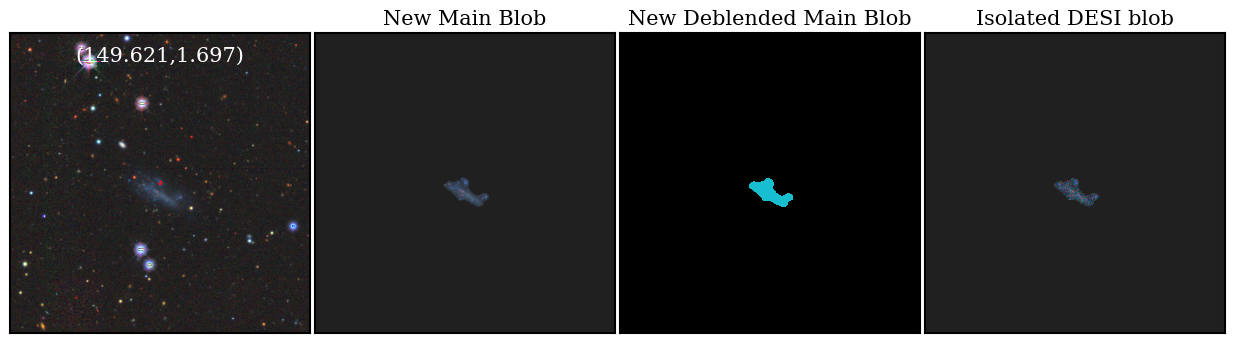

In [15]:


# for index in trange(len(tgids)):

tgids = 39627829515651432 #39627824100806546 #39633404756494781

# data_row = data_shred_all[data_shred_all["TARGETID"] == tgids[index]]
data_row = data_shred_all[data_shred_all["TARGETID"] == tgids]


img_path = data_row["IMAGE_PATH"][0]
file_path = data_row["FILE_PATH"][0]
print(file_path)


source_ra, source_dec = data_row["RA"][0], data_row["DEC"][0]
print(source_ra, source_dec)
data_arr = fits.open(img_path)[0].data
wcs = WCS(fits.getheader( img_path))
fiber_xpix, fiber_ypix,_ = wcs.all_world2pix(source_ra, source_dec,0,1)

#first estimate the background error to use in aperture photometry
noise_dict = {}

data = {"g": data_arr[0],"r":data_arr[1], "z":data_arr[2]}

npixels_min = 10
threshold_rms_scale = 1.5

rms_estimator = MADStdBackgroundRMS()
##estimate the background rms in each band!
for bii in ["g","r","z"]:        
    # Apply sigma clipping
    sigma_clip = SigmaClip(sigma=3.0,maxiters=5)
    clipped_data = sigma_clip(data[bii])
    # Estimate RMS
    background_rms = rms_estimator(clipped_data)
    noise_dict[bii] = background_rms

#the rms in the total image will be the rms in the 3 bands added in quadrature
tot_rms_tot = np.sqrt( noise_dict["g"]**2 + noise_dict["r"]**2 + noise_dict["z"]**2 )
tot_rms = noise_dict["r"]

#parameters to think a bit carefully about
threshold_org = threshold_rms_scale * tot_rms_tot

### GET THE ORIGINAL DEBLENDED SEGMENTS
kernel_org = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
tot_data_org = np.sum(data_arr, axis=0)
convolved_tot_data_org = convolve( tot_data_org, kernel_org )

segment_map_org = detect_sources(convolved_tot_data_org, threshold_org, npixels=npixels_min) 

segm_deblend_org = deblend_sources(convolved_tot_data_org,segment_map_org,
                                   npixels=10,nlevels=16, contrast=0.01,
                                   progress_bar=False)

segm_deblend_org = process_deblend_image(segment_map_org, segm_deblend_org, fiber_xpix, fiber_ypix)

###get the updated deblend values!!
kernel = make_2dgaussian_kernel(15, size=29)  # FWHM = 3.0
tot_data = data_arr[1]

threshold = threshold_rms_scale * tot_rms

convolved_tot_data = convolve( tot_data, kernel )
segment_map = detect_sources(convolved_tot_data, threshold, npixels=npixels_min) 

segment_map_data = segment_map.data

ncontrast_opt = find_optimal_ncontrast(convolved_tot_data, segment_map, nlevel_val = 4)
print(ncontrast_opt)

segm_deblend_opt = deblend_sources(convolved_tot_data,segment_map,
                                   npixels=10,nlevels=4, contrast=ncontrast_opt,
                                   progress_bar=False)


segm_deblend_opt = process_deblend_image(segment_map, segm_deblend_opt, fiber_xpix, fiber_ypix)

segm_desi_iso = np.copy(segm_deblend_opt)
new_desi_blob_id = segm_deblend_opt[ int(fiber_ypix), int(fiber_xpix) ]
##identify the one that contains the DESI source and set everything else to zero!!
segm_desi_iso[segm_desi_iso != new_desi_blob_id] = 0

##PLOTTING!!

##grz image, grz main blob in grz image, the new deblended regions, the original debledned segments
fig,ax = make_subplots(ncol = 4 , nrow = 1, return_fig = True,row_spacing = 0.1,col_spacing = 0.05)

for axi in ax:
    axi.set_xticks([])
    axi.set_yticks([])

cen_num = segment_map_data[int(fiber_ypix),int(fiber_xpix)]

segment_map_data[segment_map_data != cen_num] = 0
img_rgb = sdss_rgb(data_arr)
data_arr_mask = np.copy(data_arr)
data_arr_mask[:,segment_map_data == 0] = 0
img_rgb_mask = sdss_rgb(data_arr_mask  )

data_arr_iso = np.copy(data_arr)
data_arr_iso[:,segm_desi_iso == 0] = 0
img_iso_rgb = sdss_rgb(data_arr_iso)
    

##plot the rgb image too
# ax[-4].set_title(f"({ra:.3f},{dec:.3f})",fontsize = 10)
ax[0].imshow(img_rgb,origin="lower")
ax[1].imshow(img_rgb_mask,origin="lower")
ax[2].imshow(segm_deblend_opt,cmap = cmap_cstm,interpolation='nearest', origin="lower")
ax[3].imshow(img_iso_rgb,cmap = cmap_cstm,interpolation='nearest', origin="lower")

# ax[0].set_title(r"$grz$ image",fontsize = 15)
ax[1].set_title(r"New Main Blob",fontsize = 15)
ax[2].set_title(r"New Deblended Main Blob",fontsize = 15)
ax[3].set_title(r"Isolated DESI blob",fontsize = 15)

##add the DESI fiber
radius_in_pixels = 2*(1.5/2)/0.262 #radius of DESI fiber diameter
circle = patches.Circle( (fiber_ypix, fiber_xpix),radius_in_pixels, color='r', fill=False, linewidth=1,ls ="--")
ax[0].add_patch(circle)
# ax[0].set_title(tgids[index],fontsize = 12 )
ax[0].text(0.5,0.925,f"({source_ra:.3f},{source_dec:.3f})",fontsize = 15, transform=ax[0].transAxes,
           ha="center",va="center",color = "white")

plt.savefig(f"/pscratch/sd/v/virajvm/trash/isolate_mask_plots/example_{tgids}.pdf",bbox_inches="tight")
plt.show()


In [112]:
## what targetids are good to plot??

# plot_tgids = [39627999485624747,39628010881548661,  39628230541445186, 39627980850333137, 39627612917597701, 39627902374909225, 39633324834032193, 39627895513023722, 39633086522066102, 39632950962162682, 39627981378814611]
plot_tgids = [39627999485624747,39628010881548661,  39628230541445186,  39627612917597701,39633086522066102,39627737203215046]
              
              # 39633324834032193, 39627895513023722,  39632950962162682, 39627981378814611]



/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-240p005-250p010/2408p087/BGS_BRIGHT_tgid_39627999485624747


0.1
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-200p005-210p010/2079p092/BGS_BRIGHT_tgid_39628010881548661


0.1
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-010p015-020p020/0169p187/BGS_BRIGHT_tgid_39628230541445186


0.1
/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-170m010-180m005/1786m072/SGA_tgid_39627612917597701


0.1
/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/north/sweep-200p040-210p045/2100p405/SGA_tgid_39633086522066102


0.1
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-040m005-050p000/0473m020/BGS_BRIGHT_tgid_39627737203215046


0.1


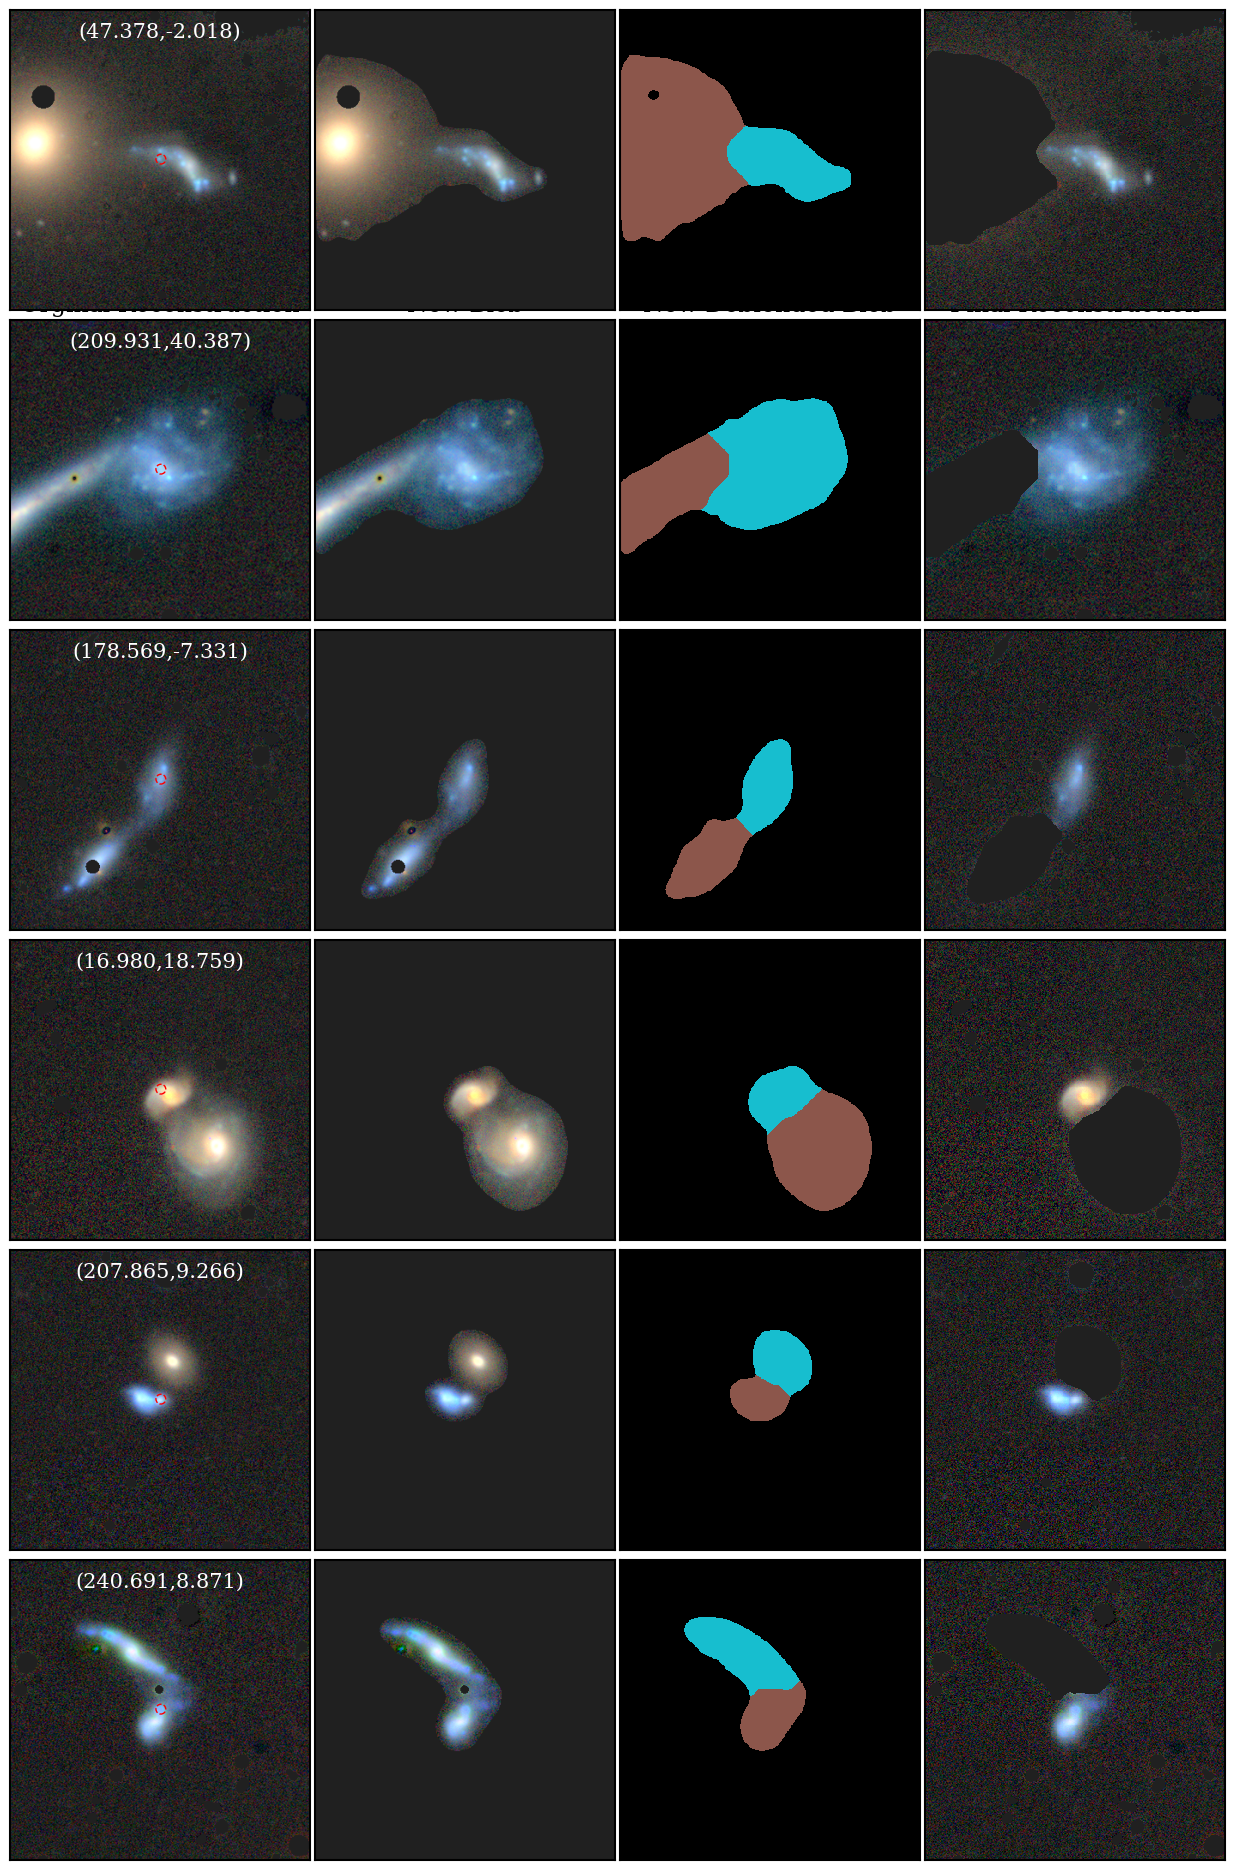

In [114]:


##grz image, grz main blob in grz image, the new deblended regions, the original debledned segments
fig,ax = make_subplots(ncol = 4 , nrow = 6, return_fig = True,row_spacing = 0.1,col_spacing = 0.05)

for axi in ax:
    axi.set_xticks([])
    axi.set_yticks([])

for plot_ind in range(len(plot_tgids)):
    ax0_ind = 4*plot_ind + 0 
    ax1_ind = 4*plot_ind + 1
    ax2_ind = 4*plot_ind + 2
    ax3_ind = 4*plot_ind + 3 
    
    
    data_row = data_shred_all[data_shred_all["TARGETID"] == plot_tgids[plot_ind]]
    
    img_path = data_row["IMAGE_PATH"][0]
    file_path = data_row["FILE_PATH"][0]
    print(file_path)
    
    source_ra, source_dec = data_row["RA"][0], data_row["DEC"][0]
    data_arr = fits.open(img_path)[0].data
    wcs = WCS(fits.getheader( img_path))
    fiber_xpix, fiber_ypix,_ = wcs.all_world2pix(source_ra, source_dec,0,1)

    #first estimate the background error to use in aperture photometry
    noise_dict = {}
    
    data = {"g": data_arr[0],"r":data_arr[1], "z":data_arr[2]}
    
    npixels_min = 10
    threshold_rms_scale = 1.5
    
    rms_estimator = MADStdBackgroundRMS()
    ##estimate the background rms in each band!
    for bii in ["g","r","z"]:        
        # Apply sigma clipping
        sigma_clip = SigmaClip(sigma=3.0,maxiters=5)
        clipped_data = sigma_clip(data[bii])
        # Estimate RMS
        background_rms = rms_estimator(clipped_data)
        noise_dict[bii] = background_rms

    #instead of loading the full original image, we load in the final reconstruction!
    #overwrite the previosu data_arr!!
    data_arr = np.load(file_path + "/final_reconstruct_galaxy.npy")
    
    #the rms in the total image will be the rms in the 3 bands added in quadrature
    tot_rms_tot = np.sqrt( noise_dict["g"]**2 + noise_dict["r"]**2 + noise_dict["z"]**2 )
    tot_rms = noise_dict["r"]
    
    #parameters to think a bit carefully about
    threshold_org = threshold_rms_scale * tot_rms_tot
    
    ### GET THE ORIGINAL DEBLENDED SEGMENTS
    kernel_org = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
    tot_data_org = np.sum(data_arr, axis=0)
    convolved_tot_data_org = convolve( tot_data_org, kernel_org )
    segment_map_org = detect_sources(convolved_tot_data_org, threshold_org, npixels=npixels_min) 
    segm_deblend_org = deblend_sources(convolved_tot_data_org,segment_map_org,
                                       npixels=10,nlevels=16, contrast=0.01,
                                       progress_bar=False)
    segment_map_data_org = segment_map_org.data
    segm_deblend_org = process_deblend_image(segment_map_org, segm_deblend_org, fiber_xpix, fiber_ypix)
    
    ###get the updated deblend values!!
    kernel = make_2dgaussian_kernel(15, size=29)  # FWHM = 3.0
    tot_data = data_arr[1]
    threshold = threshold_rms_scale * tot_rms
    convolved_tot_data = convolve( tot_data, kernel )
    segment_map = detect_sources(convolved_tot_data, threshold, npixels=npixels_min) 
    segment_map_data = segment_map.data
    ncontrast_opt = find_optimal_ncontrast(convolved_tot_data, segment_map, nlevel_val = 4)
    print(ncontrast_opt)
    segm_deblend_opt = deblend_sources(convolved_tot_data,segment_map,
                                       npixels=10,nlevels=4, contrast=ncontrast_opt,
                                       progress_bar=False)
    segm_deblend_opt = process_deblend_image(segment_map, segm_deblend_opt, fiber_xpix, fiber_ypix)
    segm_desi_iso = np.copy(segm_deblend_opt)
    new_desi_blob_id = segm_deblend_opt[ int(fiber_ypix), int(fiber_xpix) ]
    ##identify the one that contains the DESI source and set everything else to zero!!
    # segm_desi_iso[segm_desi_iso != new_desi_blob_id] = 0
    
    ##PLOTTING!!

    cen_num = segment_map_data[int(fiber_ypix),int(fiber_xpix)]
    
    segment_map_data[segment_map_data != cen_num] = 0
    img_rgb = sdss_rgb(data_arr)
    data_arr_mask = np.copy(data_arr)
    data_arr_mask[:,segment_map_data == 0] = 0
    img_rgb_mask = sdss_rgb(data_arr_mask  )
    
    
    cen_num_org = segment_map_data_org[int(fiber_ypix),int(fiber_xpix)]
    segment_map_data_org[segment_map_data_org != cen_num_org] = 0
    data_arr_mask_org = np.copy(data_arr)
    data_arr_mask_org[:,segment_map_data_org == 0] = 0
    img_rgb_mask_org = sdss_rgb(data_arr_mask_org  )
    
    
    
    data_arr_iso = np.copy(data_arr)
    mask_other_gals = ((segm_desi_iso != new_desi_blob_id) & (segm_desi_iso != 0) )

    ##binary dilate this mask to be conservative on what we are masking!
    structure = np.ones((3, 3), dtype=bool)
    mask_other_gals = binary_dilation(mask_other_gals, structure=structure, iterations=4)
    
    data_arr_iso[:,mask_other_gals ] = 0
    img_iso_rgb = sdss_rgb(data_arr_iso)
        
    
    ##plot the rgb image too
    # ax[-4].set_title(f"({ra:.3f},{dec:.3f})",fontsize = 10)
    ax[ax0_ind].imshow(img_rgb,origin="lower")
    
    # ax[1].imshow(img_rgb_mask_org, origin="lower")
    
    ax[ax1_ind].imshow(img_rgb_mask,origin="lower")
    ax[ax2_ind].imshow(segm_deblend_opt,cmap = cmap_cstm,interpolation='nearest', origin="lower")
    ax[ax3_ind].imshow(img_iso_rgb,cmap = cmap_cstm,interpolation='nearest', origin="lower")


    fs = 17
    if plot_ind == 4:
        ax[ax0_ind].set_title(r"Orginal Reconstruction",fontsize = fs)
        # ax[1].set_title(r"Original Main Blob",fontsize = 15)
        ax[ax1_ind].set_title(r"New Blob",fontsize = fs)
        ax[ax2_ind].set_title(r"New Deblended Blob",fontsize = fs)
        ax[ax3_ind].set_title(r"Final Reconstruction",fontsize = fs)

    
    ##add the DESI fiber
    radius_in_pixels = 2*(1.5/2)/0.262 #radius of DESI fiber diameter
    circle = patches.Circle( (fiber_ypix, fiber_xpix),radius_in_pixels, color='r', fill=False, linewidth=1,ls ="--")
    ax[ax0_ind].add_patch(circle)
    ax[ax0_ind].text(0.5,0.925,f"({source_ra:.3f},{source_dec:.3f})",fontsize = 15, transform=ax[ax0_ind].transAxes,
               ha="center",va="center",color = "white")

plt.savefig(f"/global/homes/v/virajvm/galaxy_image_prior/paper_1/plots/new_deblend_isolated_gals.pdf",bbox_inches="tight")
plt.show()


Let us experiment with how smoothing the image affects the final segment constructions!

In [184]:
file_path = data_shred_all[data_shred_all["TARGETID"] == 39627800730143830]["FILE_PATH"][0]
# "/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-260p015-270p020/2623p162/SGA_tgid_39628176778858306"


In [185]:
final_galaxy = np.load(file_path + "/final_reconstruct_galaxy.npy")

In [9]:
data_shred_all

NameError: name 'data_shred_all' is not defined

In [3]:
threshold_rms_scale = 1.5
npixels_min = 10

tot_rms = np.load(file_path + "/tot_noise_rms.npy")
print(tot_rms)

NameError: name 'file_path' is not defined

In [4]:
tot_image[tot_image == 0] = -1e10
print(np.min(tot_image))

NameError: name 'tot_image' is not defined

In [5]:
tot_image = np.sum(final_galaxy,axis=0)
# tot_image[tot_image < -5*tot_rms] = 0

NameError: name 'final_galaxy' is not defined

In [189]:
kernel = make_2dgaussian_kernel(15, size=29)  # FWHM = 3.0
kernel_small = make_2dgaussian_kernel(3, size=5)  # FWHM = 3.0

threshold = threshold_rms_scale * tot_rms

convolved_tot_data = convolve( tot_image , kernel )
convolved_tot_data_small = convolve( tot_image , kernel_small )

segment_map = detect_sources(convolved_tot_data, threshold, npixels=npixels_min) 
segment_map_small = detect_sources(convolved_tot_data_small, threshold, npixels=npixels_min) 


segment_map_data = segment_map.data
segment_map_data_small = segment_map_small.data


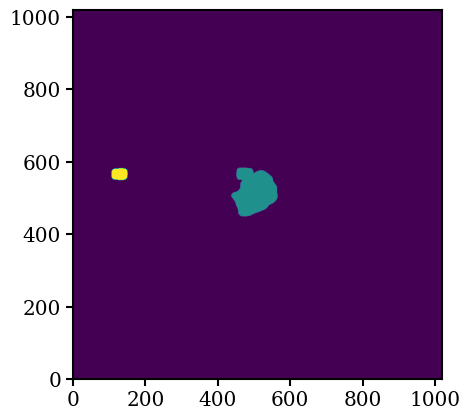

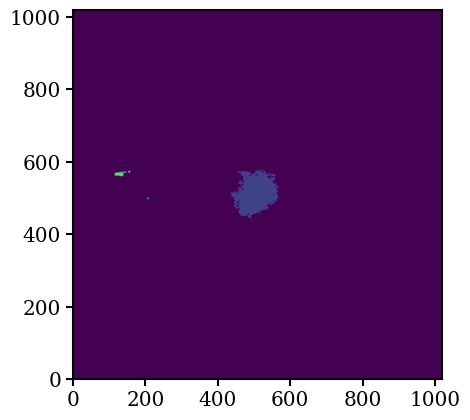

In [190]:
plt.imshow(segment_map_data,origin="lower")
plt.show()

plt.imshow(segment_map_data_small,origin="lower")
plt.show()

In [37]:
# np.argmax(data_shred_all["COG_DECREASE_MAX_MAG"][:,0])

In [36]:
# data_shred_all[data_shred_all["PCNN_FRAGMENT"] < 0.5]["FILE_PATH"]

In [8]:
Table.read("/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-260p020-270p025/2679p245/SGA_tgid_39628363777713575/parent_galaxy_sources.fits")

<Table length=17>
BRICKID OBJID  type  ... new_deblend_id    separations     marker
 int32  int32 bytes3 ...    float64          float64       bytes1
------- ----- ------ ... -------------- ------------------ ------
 468424  9243    PSF ...            3.0  52.73526194469608      p
 468424  9275    REX ...            3.0 49.271414846817244      _
 468424  9282    EXP ...            3.0  50.97878723164306      v
 468424  9318    REX ...            3.0 33.561693307288074      _
 468424  9355    REX ...            3.0 27.657587659540425      <
 468424  9364    REX ...            1.0  24.83351220011328      s
 468424  9397    REX ...            3.0 22.171696186441032      H
 468424  9411    REX ...            3.0 20.273533880275647      |
 468424  9412    REX ...            3.0  49.47691351750022      |
 468424  9413    EXP ...            3.0  46.82176520103266      |
 468424  9433    EXP ...            1.0 18.735382110581195      <
 468424  9436    SER ...            3.0  29.46719882211562      ^
 468424  9451    REX ...            1.0 16.718252110738945      >
 468424  9494    REX ...            1.0 16.658344250427742      x
 468424  9514    DEV ...            1.0 16.718378001612702      <
 468424  9607    SER ...            1.0 2.9334648218097774      x
 468424  9609    SER ...            1.0 7.6969307849660415      H

In [5]:
data_shred = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_catalog_v4.fits")


In [8]:
data_shred[data_shred["TARGETID"] == 39627684271100504]["FILE_PATH"]

<Column name='FILE_PATH' dtype='bytes128' length=1>
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-130m005-140p000/1300m042/BGS_FAINT_tgid_39627684271100504